# **Construção do ATOp-PredictiveModel**
Este notebook organiza o código gerado para a análise da autonomia de uma plataforma naval da Marinha do Brasil, utilizando dados coletados entre 2013 e 2017.

## **Ambiente e Bibliotecas**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    VotingRegressor,
    StackingRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error

import ImbalancedLearningRegression as iblr
import optuna
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

from itertools import combinations
from itertools import permutations
import time
from sklearn.model_selection import RepeatedKFold

from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

## **Integração de Dados Historicos**

### **Carregamento dos Dados**

In [2]:
# Carrega o dataset SINGRA
df_Singra = pd.read_csv('C:/Users/12078956/Documents/Projeto/Dados/SINGRA/RMC_MEIO1.csv',
                        sep=',', header=0, parse_dates=['PERIODO'],
                        dtype={'QTDE_ITENS_RM': np.float64, 'PRECO_UNITARIO_VENDA': np.float64})
# Carrega o dataset RFC
df_RFC = pd.read_csv('C:/Users/12078956/Documents/Projeto/Dados/RFC/RFC.csv',
                     sep=',', header=0) #, dtype={'MILHAS': np.float64})

### **Exploração dos Dados**

In [3]:
# Limpeza e padronização dos dados

df_Singra['GRUPO_JURISDICAO'].value_counts()

# Remove consumable items outside the scope of work
df_Singra = df_Singra.drop(df_Singra.loc[lambda df_GENEROS: ((df_Singra.NOME_PORTUGUES == 'REFEIÇÃO INDIVIDUAL') |
                                                              (df_Singra.NOME_PORTUGUES == 'RAÇÃO DE SOBREVIVÊNCIA'))].index, axis=0)

# Standardization of the Supply Unit (SU)
print('UF antes:')
print(df_Singra['UF'].value_counts())
print('\n')

# 1 Pack of coffee = 0.5 kilogram
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*0.5 if x.UF == 'PACOTE'
                                             else x.QTDE_ITENS_RM, axis = 1)
# change the description
df_Singra['UF'] = df_Singra.UF.replace('PACOTE', 'QUILOGRAMA')

# 1 Bottle of vegetable oil = 0.9 liter
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*0.9 if x.UF == 'GARRAFA'
                                             else x.QTDE_ITENS_RM, axis = 1)
df_Singra['UF'] = df_Singra.UF.replace('GARRAFA', 'LITRO') # change the description

# 1 US Quarter Gallon of lubricant = 0.946353 liter
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*0.946353 if x.UF == 'QUARTO DE GALAO AMERICANO'
                                             else x.QTDE_ITENS_RM, axis = 1)
# 1 drum of lubricant = 200 liters
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*200 if x.UF == 'TAMBOR'
                                             else x.QTDE_ITENS_RM, axis = 1)

# 1 Gallon of lubricant = 3.785412 liters
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*3.785412 if x.UF == 'GALAO'
                                             else x.QTDE_ITENS_RM, axis = 1)

# 1 Bucket of lubricant = 20 liters
# 1 Bucket of grease = 20 kilograms
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*20 if x.UF == 'BALDE'
                                             else x.QTDE_ITENS_RM, axis = 1)
# 1 Can of grease = 5 kilograms
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*5 if x.UF == 'LATA'
                                             else x.QTDE_ITENS_RM, axis = 1)

# Change UF description for Lubricant and Grease
df_Singra['UF'] = df_Singra.apply(lambda x: 'LITRO' if x.DESCRICAO_CLG == 'LUBRIFICANTE'
                                  else 'QUILOGRAMA' if x.DESCRICAO_CLG == 'GRAXA' else x.UF, axis = 1)

print('UF depois:')
print(df_Singra['UF'].value_counts())

UF antes:
UF
QUILOGRAMA                   1247
LITRO                         421
BALDE                          58
TAMBOR                         49
GARRAFA                        35
GALAO                           6
QUARTO DE GALAO AMERICANO       3
PACOTE                          3
LATA                            1
Name: count, dtype: int64


UF depois:
UF
QUILOGRAMA    1260
LITRO          563
Name: count, dtype: int64


In [4]:
df_CLG = df_Singra.query('GRUPO_JURISDICAO == "COMBUSTIVEIS"')

In [5]:
df_CLG['DESCRICAO_CLG'].value_counts()

DESCRICAO_CLG
LUBRIFICANTE                   114
ÓLEO DIESEL MARÍTIMO            90
ÓLEO DIESEL ESPECIAL - OCMT     81
COMBUSTÍVEL AVIAÇÃO - QAV-5     34
GRAXA                           14
GASOLINA COMUM                   7
Name: count, dtype: int64

In [6]:
# Remove consumable items outside the scope of work
df_CLG = df_CLG.drop(df_CLG.loc[lambda df_CLG: ((df_CLG.DESCRICAO_CLG == 'COMBUSTÍVEL AVIAÇÃO - QAV-5')
                                                | (df_CLG.DESCRICAO_CLG == 'GASOLINA COMUM'))].index, axis=0)

In [7]:
df_CLG['DESCRICAO_CLG'].value_counts()

DESCRICAO_CLG
LUBRIFICANTE                   114
ÓLEO DIESEL MARÍTIMO            90
ÓLEO DIESEL ESPECIAL - OCMT     81
GRAXA                           14
Name: count, dtype: int64

In [8]:
# Standardization of the description of CLG types
df_CLG['DESCRICAO_CLG'] = df_CLG.DESCRICAO_CLG.replace('ÓLEO DIESEL ESPECIAL - OCMT', 'COMBUSTIVEL')
df_CLG['DESCRICAO_CLG'] = df_CLG.DESCRICAO_CLG.replace('ÓLEO DIESEL MARÍTIMO', 'COMBUSTIVEL')

In [9]:
df_CLG['DESCRICAO_CLG'].value_counts()

DESCRICAO_CLG
COMBUSTIVEL     171
LUBRIFICANTE    114
GRAXA            14
Name: count, dtype: int64

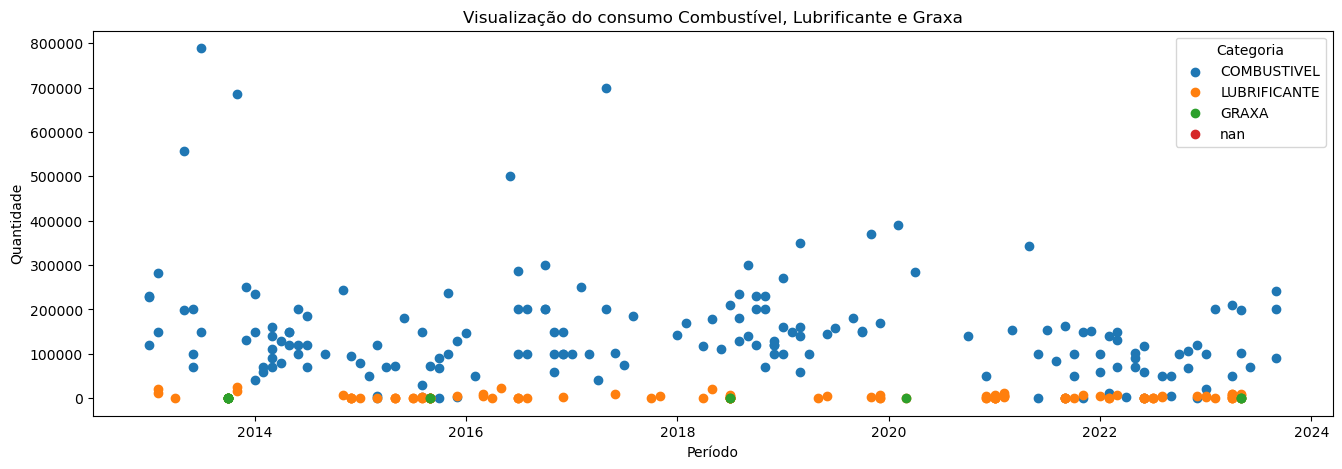

In [10]:
# Criar o gráfico de dispersão
plt.figure(figsize=(16, 5))
for category in df_CLG.DESCRICAO_CLG.unique():
    subset = df_CLG[df_CLG.DESCRICAO_CLG == category]
    plt.scatter(subset.PERIODO, subset.QTDE_ITENS_RM, label=category)

# Adicionar título e rótulos aos eixos
plt.title('Visualização do consumo Combustível, Lubrificante e Graxa')
plt.xlabel('Período')
plt.ylabel('Quantidade')
plt.legend(title='Categoria')

# Exibir o gráfico
plt.show()

In [11]:
grupoCLG = df_CLG.groupby('DESCRICAO_CLG')
grupoCLG.first()

,ANO,PERIODO,MES,SIGLA_OM,RM_TYPE,SITUACAO_RM,DESC_SITUACAO_RM,GRUPO_JURISDICAO,PI,NOME_PORTUGUES,UF,QTDE_ITENS_RM,PRECO_UNITARIO_VENDA
DESCRICAO_CLG,,,,,,,,,,,,,
COMBUSTIVEL,2013,2013-01-01,1,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,229000.0,2.14
GRAXA,2013,2013-10-01,10,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,190025257,GRAXA DE FINALIDADE GERAL,QUILOGRAMA,20.0,181.67
LUBRIFICANTE,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,190035158,ÓLEO LUBRIFICANTE DE TURBINA DE VAPOR,LITRO,12000.0,1449.90


In [12]:
grupoCLG.get_group('COMBUSTIVEL')

,ANO,PERIODO,MES,SIGLA_OM,RM_TYPE,SITUACAO_RM,DESC_SITUACAO_RM,GRUPO_JURISDICAO,DESCRICAO_CLG,PI,NOME_PORTUGUES,UF,QTDE_ITENS_RM,PRECO_UNITARIO_VENDA
0,2013,2013-01-01,1,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,229000.0,NaN
1,2013,2013-01-01,1,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,230000.0,NaN
2,2013,2013-01-01,1,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,120000.0,NaN
5,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL COMBUSTÍVEL,LITRO,150000.0,2.14
20,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024044,ÓLEO DIESEL COMBUSTÍVEL,LITRO,283093.0,2.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1805,2023,2023-05-01,5,MEIO1,RMC,SNL,FORNECIDA SEM NL PATRIMONIAL,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL COMBUSTÍVEL,LITRO,101475.0,5.27
1816,2023,2023-06-01,6,MEIO1,RMC,SNL,FORNECIDA SEM NL PATRIMONIAL,COMBUSTIVEIS,COMBUSTIVEL,190024044,ÓLEO DIESEL COMBUSTÍVEL,LITRO,69983.0,8.14
1823,2023,2023-09-01,9,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,200000.0,NaN
1824,2023,2023-09-01,9,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,241000.0,NaN


In [13]:
# Method to transform groups into columns
pivot_df_CLG = df_CLG.pivot_table(values='QTDE_ITENS_RM', index='PERIODO', columns='DESCRICAO_CLG', aggfunc='sum')

# Display the resulting DataFrame
# print(pivot_df_CLG)

In [14]:
df_GENEROS = df_Singra.query('GRUPO_JURISDICAO == "SUBSISTENCIA"')

In [15]:
df_GENEROS['NOME_PORTUGUES'].value_counts()

NOME_PORTUGUES
AÇÚCAR REFINADO                                   79
ÓLEO VEGETAL                                      77
ARROZ DESCASCADO                                  73
COXA DE FRANGO                                    70
LEITE INTEGRAL EM PÓ                              67
FEIJÕES PRETOS SECOS                              64
FILE PEITO FRANGO                                 63
GELÉIA                                            61
SUCO CAJU                                         56
MOLHO DE TOMATE                                   55
SAL DE MESA                                       54
FARINHA MANDIOCA                                  53
CAFÉ TORRADO                                      53
CREME DE LEITE                                    52
PATINHO ESPECIAL BOVINO                           47
AZEITE DE OLIVA                                   43
BIFE DO ALCATRA COM PICANHA BOVINO SEM OSSO       42
SUCO MARACUJA                                     42
LOMBO DESOSSADO                

Grupo de alimentos, baseado na pirâmida alimentar brasileira (PHILIPPI et al., 1999)
A pirâmide é composta de 8 grupos:

1.   Arroz, Pão, Massa, Batata, Mandioca;
2.   Vegetais;
1.   Frutas;
2.   Carnes;
1.   Leite, queijo and yogurte;
2.   Feijões and olaginosas;
1.   Óleos e gorduras;
2.   Açucar e doces.

In [16]:
# 02 categories were included, DRINKS (tea, coffee, etc.) and SEASONING (pepper, salt, etc.)
# Even though they are not part of the food pyramid, there were records of consumption of these items
GRUPO_ALIMENTO = []

for i in df_GENEROS.itertuples():
  valor = i.NOME_PORTUGUES

  if valor == 'AÇÚCAR REFINADO':
    GRUPO_ALIMENTO.append('ACUCARES')

  elif valor == 'ÓLEO VEGETAL':
    GRUPO_ALIMENTO.append('OLEOS_GORDURAS')

  elif valor == 'ARROZ DESCASCADO':
    GRUPO_ALIMENTO.append('ARROZ_MASSA')

  elif valor == 'COXA DE FRANGO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'LEITE INTEGRAL EM PÓ':
    GRUPO_ALIMENTO.append('LEITE_QUEIJO')

  elif valor == 'FEIJÕES PRETOS SECOS':
    GRUPO_ALIMENTO.append('FEIJOES')

  elif valor == 'FILE PEITO FRANGO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'GELÉIA':
    GRUPO_ALIMENTO.append('ACUCARES')

  elif valor == 'SUCO CAJU':
    GRUPO_ALIMENTO.append('FRUTAS')

  elif valor == 'MOLHO DE TOMATE':
    GRUPO_ALIMENTO.append('LEGUMES_VERDURAS')

  elif valor == 'FARINHA MANDIOCA':
    GRUPO_ALIMENTO.append('ARROZ_MASSA')

  elif valor == 'CREME DE LEITE':
    GRUPO_ALIMENTO.append('LEITE_QUEIJO')

  elif valor == 'PATINHO ESPECIAL BOVINO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'AZEITE DE OLIVA':
    GRUPO_ALIMENTO.append('OLEOS_GORDURAS')

  elif valor == 'BIFE DO ALCATRA COM PICANHA BOVINO SEM OSSO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'SUCO MARACUJA':
    GRUPO_ALIMENTO.append('FRUTAS')

  elif valor == 'LOMBO DESOSSADO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'ESPAGUETE':
    GRUPO_ALIMENTO.append('ARROZ_MASSA')

  elif valor == 'BISCOITO CRACKER DE TRIGO':
    GRUPO_ALIMENTO.append('ARROZ_MASSA')

  elif valor == 'LOMBO EM PEDAÇOS':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'BISCOITO DE AÇÚCAR':
    GRUPO_ALIMENTO.append('ARROZ_MASSA')

  elif valor == 'CHÃ DESOSSADO SEM MÚSCULO OU PONTA BOVINO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'MACARRÃO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'CACAU EM PÓ PARA BEBIDA':
    GRUPO_ALIMENTO.append('ACUCARES')

  elif valor == 'PERNIL DESOSSADO E AMARRADO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'BIFE DE CONTRA-FILÉ DO LOMBO BOVINO DESOSSADO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'FILÉ MIGNON COMPLETO DE CARNE BOVINA':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'FILEZINHO PEITO FRANGO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'ACÉM BOVINO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'BIFES DE CARNE BOVINA':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'BIFE DE FILÉ DE CARNE BOVINA SEM OSSO ESPECIAL':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'SUCO DE UVA ENLATADO':
    GRUPO_ALIMENTO.append('FRUTAS')

  elif valor == 'FEIJÃO-PINTO SECO':
    GRUPO_ALIMENTO.append('FEIJOES')

  elif valor == 'ARROZ PARBOILIZADO':
    GRUPO_ALIMENTO.append('ARROZ_MASSA')

  elif valor == 'BIFE BOVINO EM CUBOS ESPECIAL':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'BEBIDA COM SABOR DE FRUTA':
    GRUPO_ALIMENTO.append('FRUTAS')

  elif valor == 'ARROZ MARROM':
    GRUPO_ALIMENTO.append('ARROZ_MASSA')

  elif valor == 'CAFÉ TORRADO':
    GRUPO_ALIMENTO.append('BEBIDAS')

  else:
    GRUPO_ALIMENTO.append('TEMPEROS')

# Add Food Group column
df_GENEROS.insert(14, 'GRUPO_ALIMENTO', GRUPO_ALIMENTO)

df_GENEROS.head()

,ANO,PERIODO,MES,SIGLA_OM,RM_TYPE,SITUACAO_RM,DESC_SITUACAO_RM,GRUPO_JURISDICAO,DESCRICAO_CLG,PI,NOME_PORTUGUES,UF,QTDE_ITENS_RM,PRECO_UNITARIO_VENDA,GRUPO_ALIMENTO
3,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190010170,LOMBO EM PEDAÇOS,QUILOGRAMA,160.00,7.32,CARNES
4,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015262,GELÉIA,QUILOGRAMA,36.00,3.40,ACUCARES
7,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190008021,ESPAGUETE,QUILOGRAMA,100.00,1.75,ARROZ_MASSA
8,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190010176,LOMBO DESOSSADO,QUILOGRAMA,151.98,9.49,CARNES
9,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190007993,LEITE INTEGRAL EM PÓ,QUILOGRAMA,104.00,9.95,LEITE_QUEIJO


In [17]:
df_GENEROS['GRUPO_ALIMENTO'].value_counts()

GRUPO_ALIMENTO
CARNES              485
ARROZ_MASSA         246
ACUCARES            164
OLEOS_GORDURAS      120
LEITE_QUEIJO        119
FRUTAS              109
FEIJOES              68
TEMPEROS             56
LEGUMES_VERDURAS     55
BEBIDAS              53
Name: count, dtype: int64

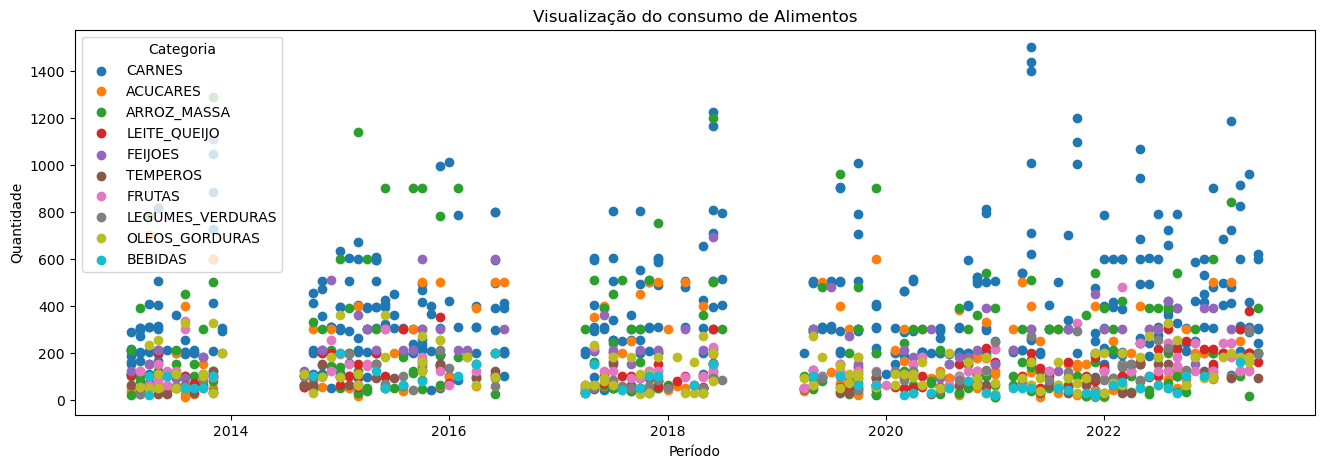

In [18]:
# Criar o gráfico de dispersão
plt.figure(figsize=(16, 5))
for category in df_GENEROS.GRUPO_ALIMENTO.unique():
    subset = df_GENEROS[df_GENEROS.GRUPO_ALIMENTO == category]
    plt.scatter(subset.PERIODO, subset.QTDE_ITENS_RM, label=category)

# Adicionar título e rótulos aos eixos
plt.title('Visualização do consumo de Alimentos')
plt.xlabel('Período')
plt.ylabel('Quantidade')
plt.legend(title='Categoria')

# Exibir o gráfico
plt.show()

In [19]:
# Method to transform groups into columns
pivot_df_GENEROS = df_GENEROS.pivot_table(values='QTDE_ITENS_RM', index='PERIODO', columns='GRUPO_ALIMENTO', aggfunc='sum')

# Display the resulting DataFrame
# print(pivot_df_GENEROS)

In [20]:
grupoGENEROS = df_GENEROS.groupby('GRUPO_ALIMENTO')
grupoGENEROS.first()

,ANO,PERIODO,MES,SIGLA_OM,RM_TYPE,SITUACAO_RM,DESC_SITUACAO_RM,GRUPO_JURISDICAO,DESCRICAO_CLG,PI,NOME_PORTUGUES,UF,QTDE_ITENS_RM,PRECO_UNITARIO_VENDA
GRUPO_ALIMENTO,,,,,,,,,,,,,,
ACUCARES,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015262,GELÉIA,QUILOGRAMA,36.00,3.40
ARROZ_MASSA,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190008021,ESPAGUETE,QUILOGRAMA,100.00,1.75
BEBIDAS,2013,2013-04-01,4,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190032164,CAFÉ TORRADO,QUILOGRAMA,20.00,12.43
CARNES,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190010170,LOMBO EM PEDAÇOS,QUILOGRAMA,160.00,7.32
FEIJOES,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190009728,FEIJÕES PRETOS SECOS,QUILOGRAMA,120.00,2.84
FRUTAS,2013,2013-03-01,3,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,120.00,4.67
LEGUMES_VERDURAS,2013,2013-03-01,3,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015107,MOLHO DE TOMATE,QUILOGRAMA,21.76,2.10
LEITE_QUEIJO,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190007993,LEITE INTEGRAL EM PÓ,QUILOGRAMA,104.00,9.95
OLEOS_GORDURAS,2013,2013-03-01,3,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190008110,ÓLEO VEGETAL,LITRO,54.00,3.34


In [21]:
grupoGENEROS.get_group('FRUTAS')

,ANO,PERIODO,MES,SIGLA_OM,RM_TYPE,SITUACAO_RM,DESC_SITUACAO_RM,GRUPO_JURISDICAO,DESCRICAO_CLG,PI,NOME_PORTUGUES,UF,QTDE_ITENS_RM,PRECO_UNITARIO_VENDA,GRUPO_ALIMENTO
31,2013,2013-03-01,3,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,120.0,4.67,FRUTAS
32,2013,2013-03-01,3,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015044,SUCO MARACUJA,LITRO,120.0,2.44,FRUTAS
50,2013,2013-04-01,4,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,60.0,4.67,FRUTAS
81,2013,2013-05-01,5,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,150.0,4.67,FRUTAS
86,2013,2013-05-01,5,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,84.0,2.88,FRUTAS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757,2023,2023-04-01,4,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015061,SUCO DE UVA ENLATADO,LITRO,120.0,5.31,FRUTAS
1763,2023,2023-04-01,4,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,120.0,3.19,FRUTAS
1783,2023,2023-05-01,5,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,168.0,3.19,FRUTAS
1800,2023,2023-05-01,5,MEIO1,RMC,SNL,FORNECIDA SEM NL PATRIMONIAL,SUBSISTENCIA,* SEM TIPO CLG *,190015044,SUCO MARACUJA,LITRO,120.0,8.10,FRUTAS


In [22]:
# Concatenates the CLG and GENEROS dataframes
df_Singra_T = pd.concat([pivot_df_CLG, pivot_df_GENEROS], axis=1)
# Impute the mean for unknown values
df_Singra_T = df_Singra_T.fillna(df_Singra_T.mean())

In [23]:
# Includes the PERIOD index as a dataframe column
df_Singra_T = df_Singra_T.rename_axis('PERIODO').reset_index()

In [24]:
df_Singra_T.head()

,PERIODO,COMBUSTIVEL,GRAXA,LUBRIFICANTE,ACUCARES,ARROZ_MASSA,BEBIDAS,CARNES,FEIJOES,FRUTAS,LEGUMES_VERDURAS,LEITE_QUEIJO,OLEOS_GORDURAS,TEMPEROS
0,2013-01-01,579000.000000,75.6,7504.373609,339.076552,573.195349,76.27451,1864.602824,286.190476,245.258065,111.867636,186.931646,207.162162,84.777778
1,2013-02-01,433093.000000,75.6,32000.000000,90.000000,330.000000,76.27451,1642.203000,120.000000,245.258065,111.867636,104.000000,207.162162,60.000000
2,2013-03-01,262525.589474,75.6,7504.373609,150.000000,626.000000,76.27451,1846.950000,286.190476,240.000000,21.760000,186.931646,54.000000,30.000000
3,2013-04-01,262525.589474,75.6,140.000000,759.400000,943.600000,120.00000,1662.200000,210.000000,60.000000,111.867636,150.000000,284.000000,60.000000
4,2013-05-01,756866.000000,75.6,7504.373609,308.000000,838.400000,76.27451,3151.660000,300.000000,318.000000,111.867636,351.200000,410.000000,114.000000


In [25]:
# Add the ANO column
ano = []
for i in df_Singra_T.itertuples():
  ano.append(i.PERIODO.year)

df_Singra_T.insert(loc=1, column='ANO', value=ano)

In [26]:
# Add the TRIMESTRE column
trimestre =[]
for i in df_Singra_T.itertuples():
  if i.PERIODO.month <= 3:
    trimestre.append(1)
  elif i.PERIODO.month <= 6:
    trimestre.append(2)
  elif i.PERIODO.month <= 9:
    trimestre.append(3)
  else:
    trimestre.append(4)

df_Singra_T.insert(loc=2, column='TRIMESTRE', value=trimestre)

In [27]:
df_Singra_T.head(10)

,PERIODO,ANO,TRIMESTRE,COMBUSTIVEL,GRAXA,LUBRIFICANTE,ACUCARES,ARROZ_MASSA,BEBIDAS,CARNES,FEIJOES,FRUTAS,LEGUMES_VERDURAS,LEITE_QUEIJO,OLEOS_GORDURAS,TEMPEROS
0,2013-01-01,2013,1,579000.000000,75.6,7504.373609,339.076552,573.195349,76.27451,1864.602824,286.190476,245.258065,111.867636,186.931646,207.162162,84.777778
1,2013-02-01,2013,1,433093.000000,75.6,32000.000000,90.000000,330.000000,76.27451,1642.203000,120.000000,245.258065,111.867636,104.000000,207.162162,60.000000
2,2013-03-01,2013,1,262525.589474,75.6,7504.373609,150.000000,626.000000,76.27451,1846.950000,286.190476,240.000000,21.760000,186.931646,54.000000,30.000000
3,2013-04-01,2013,2,262525.589474,75.6,140.000000,759.400000,943.600000,120.00000,1662.200000,210.000000,60.000000,111.867636,150.000000,284.000000,60.000000
4,2013-05-01,2013,2,756866.000000,75.6,7504.373609,308.000000,838.400000,76.27451,3151.660000,300.000000,318.000000,111.867636,351.200000,410.000000,114.000000
5,2013-06-01,2013,2,370000.000000,75.6,7504.373609,35.640000,100.000000,100.00000,208.910000,286.190476,180.000000,111.867636,186.931646,207.162162,24.000000
6,2013-07-01,2013,3,937915.000000,75.6,7504.373609,253.460000,510.000000,76.27451,971.461000,180.000000,120.000000,54.400000,100.000000,158.000000,84.777778
7,2013-08-01,2013,3,262525.589474,75.6,7504.373609,434.000000,646.000000,50.00000,1148.200000,90.000000,636.000000,56.000000,100.000000,374.000000,60.000000
8,2013-09-01,2013,3,262525.589474,75.6,7504.373609,23.760000,250.000000,50.00000,607.100000,286.190476,245.258065,111.867636,130.200000,207.162162,30.000000
9,2013-10-01,2013,4,262525.589474,151.0,1360.000000,197.520000,300.000000,50.00000,350.600000,180.000000,245.258065,84.000000,100.000000,208.000000,84.777778


In [28]:
# Sums values based on ANO and TRIMESTRE
df_SINGRA_TRIM = df_Singra_T.groupby(['ANO', 'TRIMESTRE'])[['COMBUSTIVEL', 'GRAXA',	'LUBRIFICANTE',	'ACUCARES',	'ARROZ_MASSA',
                                                            'BEBIDAS',	'CARNES',	'FEIJOES',	'FRUTAS',	'LEGUMES_VERDURAS',
                                                            'LEITE_QUEIJO',	'OLEOS_GORDURAS',	'TEMPEROS']].sum()
df_SINGRA_TRIM.head()

COMBUSTIVEL  GRAXA  LUBRIFICANTE     ACUCARES  ARROZ_MASSA  \
ANO  TRIMESTRE                                                                
2013 1          1.274619e+06  226.8  47008.747218   579.076552  1529.195349   
     2          1.389392e+06  226.8  15148.747218  1103.040000  1882.000000   
     3          1.462966e+06  226.8  22513.120827   711.220000  1406.000000   
     4          1.328019e+06  302.2  49864.373609  1276.596552  2620.000000   
2014 1          1.125000e+06  226.8  22513.120827  1017.229655  1719.586047   

                   BEBIDAS       CARNES      FEIJOES       FRUTAS  \
ANO  TRIMESTRE                                                      
2013 1          228.823529  5353.755824   692.380952   730.516129   
     2          296.274510  5022.770000   796.190476   558.000000   
     3          176.274510  2726.761000   556.190476  1001.258065   
     4          226.274510  5423.980000  1576.190476   688.516129   
2014 1          228.823529  5593.808473   858.571429   735.774194   

                LEGUMES_VERDURAS  LEITE_QUEIJO  OLEOS_GORDURAS    TEMPEROS  
ANO  TRIMESTRE                                                              
2013 1                245.495273    477.863291      468.324324  174.777778  
     2                335.602909    688.131646      901.162162  198.000000  
     3                222.267636    330.200000      739.162162  174.777778  
     4                223.867636    389.531646      760.000000  289.555556  
2014 1                335.602909    560.794937      621.486486  254.333333

In [29]:
# # Limpeza do RFC dataset
# Eliminates columns for concatenation
df_RFC = df_RFC.drop(['TV', 'DT_INICIO', 'DT_FIM', 'OPERACAO', 'PORTOS'], axis=1)

In [30]:
df_RFC.head()

,ANO,TRIMESTRE,MILITARES,DIAS_PORTO_SEDE,DIAS_PORTO_FORA_SEDE,MILHAS,DIAS_MAR
0,NaN,NaN,243,NaN,2.5,400.49,2.5
1,NaN,NaN,243,NaN,1.5,196.00,2.0
2,NaN,NaN,243,NaN,3.5,433.64,1.5
3,NaN,NaN,243,NaN,2.5,1504.59,5.5
4,NaN,NaN,243,NaN,1.5,1698.57,6.5


In [31]:
# Deletes record columns NaN
df_RFC = df_RFC.dropna()
df_RFC.reset_index(drop=True, inplace=True)

In [32]:
df_RFC.head()

,ANO,TRIMESTRE,MILITARES,DIAS_PORTO_SEDE,DIAS_PORTO_FORA_SEDE,MILHAS,DIAS_MAR
0,2013.0,1.0,227,32.0,18.0,9220.96,40.0
1,2013.0,2.0,205,33.0,16.5,6914.57,41.5
2,2013.0,3.0,184,74.5,2.0,4871.69,15.5
3,2013.0,4.0,222,59.5,7.0,6240.00,25.5
4,2014.0,1.0,261,0.0,34.5,13629.25,55.5


In [33]:
# adjust types
df_RFC['ANO'] = df_RFC.ANO.astype('int64')
df_RFC['TRIMESTRE'] = df_RFC.TRIMESTRE.astype('int64')

In [34]:
df_RFC.head()

,ANO,TRIMESTRE,MILITARES,DIAS_PORTO_SEDE,DIAS_PORTO_FORA_SEDE,MILHAS,DIAS_MAR
0,2013,1,227,32.0,18.0,9220.96,40.0
1,2013,2,205,33.0,16.5,6914.57,41.5
2,2013,3,184,74.5,2.0,4871.69,15.5
3,2013,4,222,59.5,7.0,6240.00,25.5
4,2014,1,261,0.0,34.5,13629.25,55.5


In [35]:
# Defines the columns ANO and TRIMESTRE as indexes
df_RFC = df_RFC.set_index(['ANO', 'TRIMESTRE'])

In [36]:
df_RFC.head()

MILITARES  DIAS_PORTO_SEDE  DIAS_PORTO_FORA_SEDE    MILHAS  \
ANO  TRIMESTRE                                                               
2013 1                227             32.0                  18.0   9220.96   
     2                205             33.0                  16.5   6914.57   
     3                184             74.5                   2.0   4871.69   
     4                222             59.5                   7.0   6240.00   
2014 1                261              0.0                  34.5  13629.25   

                DIAS_MAR  
ANO  TRIMESTRE            
2013 1              40.0  
     2              41.5  
     3              15.5  
     4              25.5  
2014 1              55.5

In [37]:
# Concatenates the SINGRA_TRIM and RFC dataframes
df_ATOp = pd.concat([df_SINGRA_TRIM, df_RFC], axis=1)

In [38]:
df_ATOp.head()

COMBUSTIVEL  GRAXA  LUBRIFICANTE     ACUCARES  ARROZ_MASSA  \
ANO  TRIMESTRE                                                                
2013 1          1.274619e+06  226.8  47008.747218   579.076552  1529.195349   
     2          1.389392e+06  226.8  15148.747218  1103.040000  1882.000000   
     3          1.462966e+06  226.8  22513.120827   711.220000  1406.000000   
     4          1.328019e+06  302.2  49864.373609  1276.596552  2620.000000   
2014 1          1.125000e+06  226.8  22513.120827  1017.229655  1719.586047   

                   BEBIDAS       CARNES      FEIJOES       FRUTAS  \
ANO  TRIMESTRE                                                      
2013 1          228.823529  5353.755824   692.380952   730.516129   
     2          296.274510  5022.770000   796.190476   558.000000   
     3          176.274510  2726.761000   556.190476  1001.258065   
     4          226.274510  5423.980000  1576.190476   688.516129   
2014 1          228.823529  5593.808473   858.571429   735.774194   

                LEGUMES_VERDURAS  LEITE_QUEIJO  OLEOS_GORDURAS    TEMPEROS  \
ANO  TRIMESTRE                                                               
2013 1                245.495273    477.863291      468.324324  174.777778   
     2                335.602909    688.131646      901.162162  198.000000   
     3                222.267636    330.200000      739.162162  174.777778   
     4                223.867636    389.531646      760.000000  289.555556   
2014 1                335.602909    560.794937      621.486486  254.333333   

                MILITARES  DIAS_PORTO_SEDE  DIAS_PORTO_FORA_SEDE    MILHAS  \
ANO  TRIMESTRE                                                               
2013 1              227.0             32.0                  18.0   9220.96   
     2              205.0             33.0                  16.5   6914.57   
     3              184.0             74.5                   2.0   4871.69   
     4              222.0             59.5                   7.0   6240.00   
2014 1              261.0              0.0                  34.5  13629.25   

                DIAS_MAR  
ANO  TRIMESTRE            
2013 1              40.0  
     2              41.5  
     3              15.5  
     4              25.5  
2014 1              55.5

In [39]:
# Inclui o index ANO e TRIMESTRE como coluna do dataframe
df_ATOp = df_ATOp.rename_axis(['ANO', 'TRIMESTRE']).reset_index()

In [40]:
df_ATOp_rounder = df_ATOp.round(2)

In [41]:
df_ATOp_rounder.head(10)

,ANO,TRIMESTRE,COMBUSTIVEL,GRAXA,LUBRIFICANTE,ACUCARES,ARROZ_MASSA,BEBIDAS,CARNES,FEIJOES,FRUTAS,LEGUMES_VERDURAS,LEITE_QUEIJO,OLEOS_GORDURAS,TEMPEROS,MILITARES,DIAS_PORTO_SEDE,DIAS_PORTO_FORA_SEDE,MILHAS,DIAS_MAR
0,2013,1,1274618.59,226.8,47008.75,579.08,1529.20,228.82,5353.76,692.38,730.52,245.50,477.86,468.32,174.78,227.0,32.0,18.0,9220.96,40.0
1,2013,2,1389391.59,226.8,15148.75,1103.04,1882.00,296.27,5022.77,796.19,558.00,335.60,688.13,901.16,198.00,205.0,33.0,16.5,6914.57,41.5
2,2013,3,1462966.18,226.8,22513.12,711.22,1406.00,176.27,2726.76,556.19,1001.26,222.27,330.20,739.16,174.78,184.0,74.5,2.0,4871.69,15.5
3,2013,4,1328018.59,302.2,49864.37,1276.60,2620.00,226.27,5423.98,1576.19,688.52,223.87,389.53,760.00,289.56,222.0,59.5,7.0,6240.00,25.5
4,2014,1,1125000.00,226.8,22513.12,1017.23,1719.59,228.82,5593.81,858.57,735.77,335.60,560.79,621.49,254.33,261.0,0.0,34.5,13629.25,55.5
5,2014,2,1050000.00,226.8,22513.12,1017.23,1719.59,228.82,5593.81,858.57,735.77,335.60,560.79,621.49,254.33,261.0,0.0,41.0,10721.90,50.0
6,2014,3,475000.00,151.2,15008.75,392.54,633.20,152.55,1924.60,406.19,451.26,213.87,340.93,315.16,144.78,261.0,9.5,31.5,13145.04,51.0
7,2014,4,601491.59,226.8,16144.37,979.16,1237.60,252.55,4662.00,1006.19,862.52,335.60,497.20,306.00,294.78,196.0,79.5,3.0,1151.00,9.5
8,2015,1,255469.00,226.8,7980.08,1021.50,2798.80,352.55,6896.40,932.38,660.00,399.87,364.00,831.16,234.78,219.0,66.5,4.0,4041.05,19.5
9,2015,2,322166.00,226.8,15545.53,978.15,2240.40,246.27,7275.60,796.19,1139.26,330.27,686.73,954.32,409.56,240.0,61.0,3.5,5178.05,26.5


In [42]:
# Removes records outside the study period (2013 to 2017)
df_ATOp = df_ATOp.drop(df_ATOp.loc[lambda df_ATOp: df_ATOp.ANO > 2017].index, axis=0)
df_ATOp.reset_index(drop=True, inplace=True)

In [43]:
# Correlation Matrix
matriz_correlacao = df_ATOp.corr(method="spearman")
matriz_correlacao.style.background_gradient(cmap="coolwarm")

,ANO,TRIMESTRE,COMBUSTIVEL,GRAXA,LUBRIFICANTE,ACUCARES,ARROZ_MASSA,BEBIDAS,CARNES,FEIJOES,FRUTAS,LEGUMES_VERDURAS,LEITE_QUEIJO,OLEOS_GORDURAS,TEMPEROS,MILITARES,DIAS_PORTO_SEDE,DIAS_PORTO_FORA_SEDE,MILHAS,DIAS_MAR
ANO,1.000000,0.000000,-0.459855,-0.149215,-0.111204,0.107705,0.101550,0.166934,0.187715,-0.043115,-0.302839,-0.055945,0.052314,-0.154451,0.253784,0.128953,0.126169,-0.165735,-0.282044,-0.190216
TRIMESTRE,0.000000,1.000000,0.224914,-0.016654,-0.265698,0.233550,-0.101205,-0.301094,-0.108990,0.081804,0.003909,-0.342032,-0.046710,-0.164108,0.321014,-0.295160,0.210195,-0.147524,-0.255937,-0.263891
COMBUSTIVEL,-0.459855,0.224914,1.000000,0.308911,0.353040,0.141888,-0.194718,-0.128890,-0.153963,0.024925,0.073515,-0.184469,0.036227,-0.068184,-0.286920,-0.231928,-0.267172,0.207001,0.261654,0.188864
GRAXA,-0.149215,-0.016654,0.308911,1.000000,0.657226,0.482946,0.627721,0.409181,0.492669,0.588192,0.273406,0.246615,0.122087,0.439235,0.428123,-0.288895,0.050780,-0.078123,-0.191590,-0.191734
LUBRIFICANTE,-0.111204,-0.265698,0.353040,0.657226,1.000000,-0.044107,0.114069,0.121467,0.033460,0.264841,0.016037,0.037635,0.028898,0.097710,0.131549,-0.021245,-0.004563,-0.046266,-0.012122,-0.089464
ACUCARES,0.107705,0.233550,0.141888,0.482946,-0.044107,1.000000,0.536364,0.509138,0.754545,0.739955,-0.002282,0.340491,0.481818,0.258557,0.470865,-0.318217,-0.003030,0.068002,-0.166794,-0.064955
ARROZ_MASSA,0.101550,-0.101205,-0.194718,0.627721,0.114069,0.536364,1.000000,0.424662,0.653030,0.436695,-0.020540,0.436900,0.201515,0.771108,0.451817,0.003779,0.036364,-0.043068,-0.189435,-0.094411
BEBIDAS,0.166934,-0.301094,-0.128890,0.409181,0.121467,0.509138,0.424662,1.000000,0.563172,0.522091,-0.116928,0.566880,0.426184,0.209320,0.293915,-0.294616,0.301373,-0.216704,-0.476135,-0.345989
CARNES,0.187715,-0.108990,-0.153963,0.492669,0.033460,0.754545,0.653030,0.563172,1.000000,0.590599,0.232790,0.407824,0.487879,0.301143,0.536390,-0.064248,-0.065152,0.091425,-0.139624,-0.024925
FEIJOES,-0.043115,0.081804,0.024925,0.588192,0.264841,0.739955,0.436695,0.522091,0.590599,1.000000,0.149601,0.624069,0.490523,0.264080,0.558146,-0.166415,0.025777,0.128545,-0.157857,-0.128497


In [44]:
df_ATOp.corr(method="spearman").DIAS_MAR.sort_values()

DIAS_PORTO_SEDE        -0.953932
TEMPEROS               -0.494512
BEBIDAS                -0.345989
TRIMESTRE              -0.263891
GRAXA                  -0.191734
ANO                    -0.190216
FEIJOES                -0.128497
OLEOS_GORDURAS         -0.124340
ARROZ_MASSA            -0.094411
LUBRIFICANTE           -0.089464
FRUTAS                 -0.081534
ACUCARES               -0.064955
CARNES                 -0.024925
LEITE_QUEIJO           -0.011329
LEGUMES_VERDURAS        0.026318
COMBUSTIVEL             0.188864
MILITARES               0.574981
DIAS_PORTO_FORA_SEDE    0.880979
MILHAS                  0.966140
DIAS_MAR                1.000000
Name: DIAS_MAR, dtype: float64

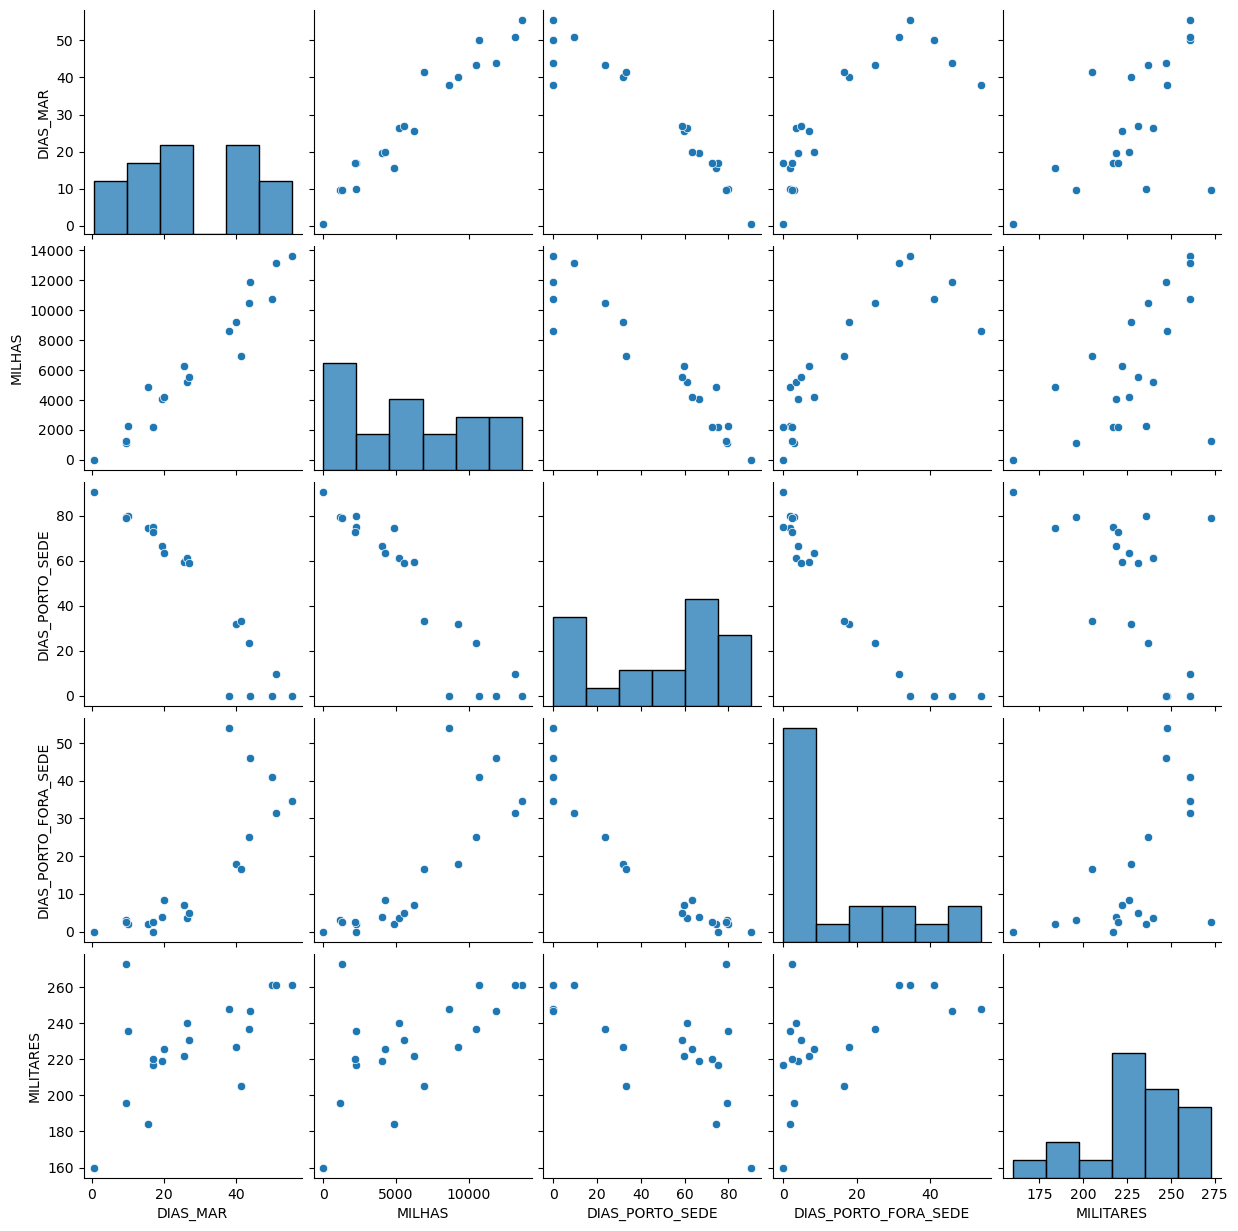

In [45]:
sns.pairplot(df_ATOp[['DIAS_MAR', 'MILHAS', 'DIAS_PORTO_SEDE', 'DIAS_PORTO_FORA_SEDE', 'MILITARES']])

### **Preparação dos Dados**

<Axes: ylabel='DIAS_MAR'>

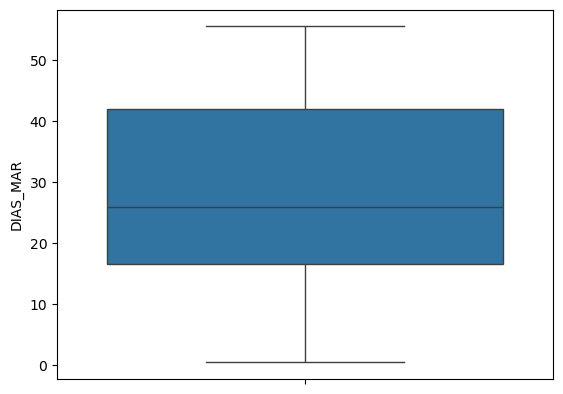

In [46]:
sns.boxplot(df_ATOp['DIAS_MAR'])

In [47]:
# Aplicação da técnica de sobreamostragem sobre os dados reais

## specify phi relevance values
rg_mtrx_iblr = [

    [42,  1, 0],  ## over-sample ("minority")
    [30, 0, 0],  ## under-sample ("majority")
    [20, 0, 0],  ## under-sample
    [31, 0, 0],  ## under-sample
]

## conduct Random Over-sampling

df_ATOp_RO = iblr.gn(
    data = df_ATOp, ## pandas dataframe
    y = 'DIAS_MAR',            ## string ('header name')
    pert = 0.02,              ## perturbation / noise percentage (pos real) #gaussian
    samp_method = 'extreme',   ## string ('balance' or 'extreme')
    drop_na_col = True,        ## boolean (True or False)
    drop_na_row = True,        ## boolean (True or False)
    replace = True,           ## boolean (True or False)
    manual_perc = True,      ## user defines percentage of under-sampling and over-sampling  # added
    perc_u = 0.9,              ## percentage of under-sampling  # added
    perc_o = 100,              ## percentage of over-sampling  # added

    ## phi relevance arguments
    rel_thres = 0.8,               ## real number (0 < R < 1)
    rel_method = 'manual',         ## string ('auto' or 'manual')
    # rel_xtrm_type = 'both',      ## unused (rel_method = 'manual')
    # rel_coef = 1.50,             ## unused (rel_method = 'manual')
    rel_ctrl_pts_rg = rg_mtrx_iblr ## 2d array (format: [x, y])
)

synth_matrix: 100%|##########| 5/5 [00:04<00:00,  1.01it/s]


In [48]:
# Conjuntos de Dados

# Atributo Alvo
# Conjunto Real
y = df_ATOp['DIAS_MAR']
# Conjunto Derivado
y_s = df_ATOp_RO['DIAS_MAR']

# Atrbutos prediditivos exceto colunas eliminadas
# Conjunto Real
X = df_ATOp.drop(['ANO', 'TRIMESTRE', 'MILHAS', 'DIAS_MAR'], axis=1)
# Conjunto Derivado
X_s = df_ATOp_RO.drop(['ANO', 'TRIMESTRE', 'MILHAS', 'DIAS_MAR'], axis=1)

## **Treinamento, Teste e Validação**

In [49]:
# Parâmetros globais

N_SPLITS = 10
RANDOM_STATE=0
KF = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
CV = RepeatedKFold(n_splits=N_SPLITS, n_repeats=5, random_state=RANDOM_STATE)
N_TRIALS=50
N_RUNS=5  # número de vezes que o modelo roda com colunas embaralhadas
N_COLS=2  # número de subconjuntos de atributos

### **Bloco Experimental 1 - Modelos Individuais**

In [50]:
# Função unificada de otimização de hiperparâmetros com Optuna
def otimizar_modelos_individuais(model_name, X_train, y_train):
    def objective(trial):
        if model_name == "LinearRegression":
            model = LinearRegression()

        elif model_name == "DecisionTree":
            params = {
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5)
            }
            model = DecisionTreeRegressor(**params, random_state=RANDOM_STATE)

        elif model_name == "RandomForest":
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 150),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5)
            }
            model = RandomForestRegressor(**params, random_state=RANDOM_STATE)

        elif model_name == "GradientBoosting":
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 200),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
                'max_depth': trial.suggest_int('max_depth', 3, 10)
            }
            model = GradientBoostingRegressor(**params, random_state=RANDOM_STATE)

        elif model_name == "KNeighbors":
            params = {
                'n_neighbors': trial.suggest_int('n_neighbors', 1, 10),
                'weights': trial.suggest_categorical('weights', ['uniform', 'distance'])
            }
            model = KNeighborsRegressor(**params)

        else:
            raise ValueError(f"Modelo desconhecido: {model_name}")

        return cross_val_score(model, X_train, y_train, cv=KF, scoring='r2', n_jobs=-1).mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=N_TRIALS, n_jobs=-1)

    return study.best_params, study

# Execução do Pipeline de otimização dos modelos
def executar_pipeline_modelos_individuais(X, y, model_names=None):
    if model_names is None:
        model_names = ["LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting", "KNeighbors"]

    models_params = {}
    study_results = {}
    tempos_execucao_total = {}
    modelos_treinados = {}

    melhor_modelo = None
    melhor_score = -np.inf

    for name in model_names:
        print(f"\nOtimizando modelo: {name}")
        inicio = time.perf_counter()

        # Otimização
        params, study = otimizar_modelos_individuais(name, X, y)
        models_params[name] = params
        study_results[name] = study

        # Criação do modelo com melhores hiperparâmetros
        if name == "LinearRegression":
            modelo = make_pipeline(StandardScaler(), LinearRegression())
        elif name == "DecisionTree":
            modelo = DecisionTreeRegressor(random_state=RANDOM_STATE, **params)
        elif name == "RandomForest":
            modelo = RandomForestRegressor(random_state=RANDOM_STATE, **params)
        elif name == "GradientBoosting":
            modelo = GradientBoostingRegressor(random_state=RANDOM_STATE, **params)
        elif name == "KNeighbors":
            modelo = make_pipeline(StandardScaler(), KNeighborsRegressor(**params))
        else:
            raise ValueError(f"Modelo desconhecido: {name}")

        modelos_treinados[name] = modelo

        # Avaliação
        r2_scores = cross_val_score(modelo, X, y, cv=KF, scoring='r2', n_jobs=-1)
        rmse_scores = np.sqrt(-cross_val_score(modelo, X, y, cv=KF, scoring='neg_mean_squared_error', n_jobs=-1))

        fim = time.perf_counter()
        tempo_total = fim - inicio
        tempos_execucao_total[name] = tempo_total

        # Armazenamento
        media_r2 = np.mean(r2_scores)
        models_params[name]["R2 Média"] = media_r2
        models_params[name]["R2 Std"] = np.std(r2_scores)
        models_params[name]["RMSE Média"] = np.mean(rmse_scores)
        models_params[name]["RMSE Std"] = np.std(rmse_scores)

        # Atualizar melhor modelo
        if media_r2 > melhor_score:
            melhor_score = media_r2
            melhor_modelo = modelo

    # Impressão dos resultados
    print("\nMelhores hiperparâmetros encontrados:")
    for model, study in study_results.items():
        print(f"{model}: {study.best_params}")
    print("\nResultados e Tempos de Treinamento:")
    for name in model_names:
        print(f"\n{name}")
        print(f"Tempo Total: {tempos_execucao_total[name]:.2f} segundos")
        print(f"Média do R²: {models_params[name]['R2 Média']:.4f} ± {models_params[name]['R2 Std']:.4f}")
        print(f"Média do RMSE: {models_params[name]['RMSE Média']:.4f} ± {models_params[name]['RMSE Std']:.4f}")

    return models_params, study_results, tempos_execucao_total, melhor_modelo

### **Bloco Experimental 2 - Comitês de Modelos sem Direcionamento Semântico**

#### Treinamento de Comitês de Modelos sem Direcionamento Semântico com divisão em dois subconjuntos

In [51]:
# ================================================
# # Classe principal
# ================================================
class ComiteModelosStacking(BaseEstimator, RegressorMixin):
    def __init__(self, model_names=("Linear Regression", "Decision Tree", "Random Forest", "Gradient Boosting", "K-Nearest Neighbors"),
                 model_params=None, meta_model=None, n_runs=N_RUNS, n_cols=N_COLS, random_state=None):
        self.model_names = model_names
        self.model_params = model_params or {}
        self.meta_model = meta_model or Ridge()
        self.n_runs = n_runs
        self.n_cols = n_cols
        self.random_state = random_state

    def _get_model(self, name, params):
        if name == "Linear Regression":
            return LinearRegression(**params)
        elif name == "Decision Tree":
            return DecisionTreeRegressor(**params)
        elif name == "Random Forest":
            return RandomForestRegressor(**params)
        elif name == "Gradient Boosting":
            return GradientBoostingRegressor(**params)
        elif name == "K-Nearest Neighbors":
            return KNeighborsRegressor(**params)
        else:
            raise ValueError(f"Modelo desconhecido: {name}")

    def fit(self, X, y):
        self.ensembles_ = []
        self.cols_used_ = []
        rng = np.random.RandomState(self.random_state)
        all_cols = list(X.columns)

        for _ in range(self.n_runs):
            rng.shuffle(all_cols)
            splits = np.array_split(all_cols, self.n_cols)
            cols_list = [list(split) for split in splits]
            self.cols_used_.append([cols.copy() for cols in cols_list])

            estimators = []
            for i, (model_name, cols) in enumerate(zip(self.model_names, cols_list)):
                prefix = f"{i}_"
                params = extract_params(self.model_params.get(model_name, {}), prefix)
                model = self._get_model(model_name, params)
                model.fit(X[cols], y)
                estimators.append((f"model{i+1}", model))

            ensemble = StackingRegressor(
                estimators=estimators,
                final_estimator=clone(self.meta_model),
                passthrough=False
            )
            ensemble.fit(X[all_cols], y)
            self.ensembles_.append((ensemble, [c.copy() for c in cols_list]))

        return self

    def predict(self, X):
        preds = []
        for ensemble, cols_list in self.ensembles_:
            used_cols = [col for cols in cols_list for col in cols]
            X_used = X[used_cols].copy()
            preds.append(ensemble.predict(X_used))
        return np.mean(preds, axis=0)

# ====================================
# Sugestão de hiperparâmetros por modelo
# ====================================
def suggest_params(trial, model_name, prefix=""):
    if model_name == "Decision Tree":
        return {
            f'{prefix}max_depth': trial.suggest_int(f'{prefix}max_depth', 3, 10),
            f'{prefix}min_samples_split': trial.suggest_int(f'{prefix}min_samples_split', 2, 10),
            f'{prefix}min_samples_leaf': trial.suggest_int(f'{prefix}min_samples_leaf', 1, 5)
        }
    elif model_name == "Random Forest":
        return {
            f'{prefix}n_estimators': trial.suggest_int(f'{prefix}n_estimators', 50, 150),
            f'{prefix}max_depth': trial.suggest_int(f'{prefix}max_depth', 3, 10),
            f'{prefix}min_samples_split': trial.suggest_int(f'{prefix}min_samples_split', 2, 10),
            f'{prefix}min_samples_leaf': trial.suggest_int(f'{prefix}min_samples_leaf', 1, 5)
        }
    elif model_name == "Gradient Boosting":
        return {
            f'{prefix}n_estimators': trial.suggest_int(f'{prefix}n_estimators', 100, 200),
            f'{prefix}learning_rate': trial.suggest_float(f'{prefix}learning_rate', 0.01, 0.2),
            f'{prefix}max_depth': trial.suggest_int(f'{prefix}max_depth', 3, 10)
        }
    elif model_name == "K-Nearest Neighbors":
        return {
            f'{prefix}n_neighbors': trial.suggest_int(f'{prefix}n_neighbors', 1, 10),
            f'{prefix}weights': trial.suggest_categorical(f'{prefix}weights', ['uniform', 'distance'])
        }
    elif model_name == "Linear Regression":
        return {}
    else:
        raise ValueError(f"Modelo desconhecido: {model_name}")

def extract_params(params_dict, prefix):
    return {k.replace(prefix, ""): v for k, v in params_dict.items() if k.startswith(prefix)}

# ====================================
# Treinar dois modelos específicos
# ====================================
class ComiteModelos2Stacking(BaseEstimator, RegressorMixin):
    def __init__(self, model_names=("Gradient Boosting", "Linear Regression"),
                 model_params=None, meta_model=None, n_runs=1, random_state=None):
        self.model_names = model_names
        self.model_params = model_params or {}
        self.meta_model = meta_model or Ridge()
        self.n_runs = n_runs
        self.random_state = random_state

    def _get_model(self, name, params):
        if name == "Linear Regression":
            return LinearRegression(**params)
        elif name == "Decision Tree":
            return DecisionTreeRegressor(**params)
        elif name == "Random Forest":
            return RandomForestRegressor(**params)
        elif name == "Gradient Boosting":
            return GradientBoostingRegressor(**params)
        elif name == "K-Nearest Neighbors":
            return KNeighborsRegressor(**params)
        else:
            raise ValueError(f"Modelo desconhecido: {name}")

    def fit(self, X, y):
        self.ensembles_ = []
        self.cols_used_ = []
        rng = np.random.RandomState(self.random_state)
        all_cols = list(X.columns)

        for _ in range(self.n_runs):
            rng.shuffle(all_cols)
            split_idx = len(all_cols) // 2
            cols1, cols2 = all_cols[:split_idx], all_cols[split_idx:]

            params1 = extract_params(self.model_params.get(self.model_names[0], {}), "0_")
            params2 = extract_params(self.model_params.get(self.model_names[1], {}), "1_")

            model1 = self._get_model(self.model_names[0], params1)
            model2 = self._get_model(self.model_names[1], params2)

            model1.fit(X[cols1], y)
            model2.fit(X[cols2], y)

            ensemble = StackingRegressor(
                estimators=[
                    ("model1", model1),
                    ("model2", model2)
                ],
                final_estimator=clone(self.meta_model),
                passthrough=False
            )
            ensemble.fit(X, y)

            self.ensembles_.append((ensemble, cols1, cols2))

        return self

    def predict(self, X):
        preds = []
        for ensemble, cols1, cols2 in self.ensembles_:
            X_used = X.copy()
            preds.append(ensemble.predict(X_used))
        return np.mean(preds, axis=0)

# ====================================
# Pipeline de execução para todas as combinações de 5 modelos, tomados 2 a 2
# ====================================
def executar_pipeline_comite_stacking_5modelos(X, y, n_trials=N_TRIALS, n_splits=N_SPLITS, n_runs=N_RUNS, n_cols=N_COLS):
    all_model_names = [
        "Linear Regression",
        "Decision Tree",
        "Random Forest",
        "Gradient Boosting",
        "K-Nearest Neighbors"
    ]

    results = {}
    for model_names in permutations(all_model_names, n_cols):
        print(f"\n Otimizando conjunto com Stacking e 2 divisões de colunas: {model_names}")

        def objective(trial):
            params = {
                name: suggest_params(trial, name, prefix=f"{i}_")
                for i, name in enumerate(model_names)
            }
            model = ComiteModelosStacking(
                model_names=model_names,
                model_params=params,
                meta_model=Ridge(),
                n_runs=n_runs,
                n_cols = n_cols,
                random_state=RANDOM_STATE
            )

            scores = []
            for train_idx, val_idx in KF.split(X):
                model.fit(X.iloc[train_idx], y.iloc[train_idx])
                pred = model.predict(X.iloc[val_idx])
                scores.append(r2_score(y.iloc[val_idx], pred))

            return np.mean(scores)

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_trials)

        best_params = {
            name: extract_params(study.best_params, f"{i}_")
            for i, name in enumerate(model_names)
        }

        model = ComiteModelosStacking(
            model_names=model_names,
            model_params={name: best_params[name] for name in model_names},
            meta_model=Ridge(),
            n_runs=n_runs,
            n_cols = n_cols,
            random_state=RANDOM_STATE
        )

        r2_scores, rmse_scores = [], []
        for train_idx, test_idx in KF.split(X):
            model.fit(X.iloc[train_idx], y.iloc[train_idx])
            pred = model.predict(X.iloc[test_idx])
            r2_scores.append(r2_score(y.iloc[test_idx], pred))
            rmse_scores.append(root_mean_squared_error(y.iloc[test_idx], pred))

        results[" + ".join(model_names)] = {
            "R2 Média": np.mean(r2_scores),
            "R2 Std": np.std(r2_scores),
            "RMSE Média": np.mean(rmse_scores),
            "RMSE Std": np.std(rmse_scores),
            "Tempo Total (s)": study.best_trial.duration.total_seconds()
        }

    df_results = pd.DataFrame(results).T.sort_values("R2 Média", ascending=False)
    print("\n Resultados finais com Stacking e 2 divisões de colunas:")
    print(df_results.round(4))
    return df_results

#### Treinamento de Comitês de Modelos sem Direcionamento Semântico com formações completamente aleatórias

In [52]:
# Função para divisão aleatória e desbalanceada de colunas
def dividir_colunas_aleatorio_desbalanceado(colunas, n_modelos, rng):
    rng.shuffle(colunas)
    divisao_inicial = [[coluna] for coluna in colunas[:n_modelos]]
    colunas_restantes = colunas[n_modelos:]
    for coluna in colunas_restantes:
        idx = rng.randint(0, n_modelos)
        divisao_inicial[idx].append(coluna)
    return divisao_inicial

# Pipeline principal
def executar_pipeline_execucoes_aleatorias(X, y, n_trials=N_TRIALS, n_splits=N_SPLITS):
    all_model_names = [
        "Linear Regression",
        "Decision Tree",
        "Random Forest",
        "Gradient Boosting",
        "K-Nearest Neighbors"
    ]

    rng_global = np.random.RandomState(RANDOM_STATE)
    results = {}

    for execucao in range(N_EXECUCOES):
        # Sorteia quantos modelos (2, 3, 4 ou 5)
        n_modelos = rng_global.choice([2, 3, 4, 5])
        # Sorteia os modelos
        model_names = rng_global.choice(all_model_names, size=n_modelos, replace=False)
        print(f"\nExecução {execucao+1}/{N_EXECUCOES}: otimizando conjunto de {n_modelos} modelos -> {model_names}")

        def objective(trial):
            params = {
                name: suggest_params(trial, name, prefix=f"{i}_")
                for i, name in enumerate(model_names)
            }
            model = ComiteModelosStacking(
                model_names=model_names,
                model_params=params,
                meta_model=Ridge(),
                n_runs=1,
                random_state=rng_global.randint(0, 10000)
            )

            splits = list(KF.split(X))
            scores = []
            for train_idx, val_idx in splits:
                model.fit(X.iloc[train_idx], y.iloc[train_idx])
                pred = model.predict(X.iloc[val_idx])
                scores.append(r2_score(y.iloc[val_idx], pred))
            return np.mean(scores)

        inicio_total = time.perf_counter()
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_trials)
        fim_total = time.perf_counter()
        tempo_total = fim_total - inicio_total

        best_params = {
            name: extract_params(study.best_params, f"{i}_")
            for i, name in enumerate(model_names)
        }

        model = ComiteModelosStacking(
            model_names=model_names,
            model_params={name: best_params[name] for name in model_names},
            meta_model=Ridge(),
            n_runs=1,
            random_state=rng_global.randint(0, 10000)
        )

        r2_scores, rmse_scores = [], []
        for train_idx, test_idx in KF.split(X):
            model.fit(X.iloc[train_idx], y.iloc[train_idx])
            pred = model.predict(X.iloc[test_idx])
            r2_scores.append(r2_score(y.iloc[test_idx], pred))
            rmse_scores.append(root_mean_squared_error(y.iloc[test_idx], pred))

        label = f"Execução {execucao+1}: {' + '.join(model_names)}"
        results[label] = {
            "N Modelos": n_modelos,
            "Modelos": " + ".join(model_names),
            "R2 Média": np.mean(r2_scores),
            "R2 Std": np.std(r2_scores),
            "RMSE Média": np.mean(rmse_scores),
            "RMSE Std": np.std(rmse_scores),
            "Tempo Total (s)": tempo_total
        }

    df_results = pd.DataFrame(results).T.sort_values("R2 Média", ascending=False)
    print("\nResultados finais (ordem decrescente de R²):")
    print(df_results.round(4))
    return df_results

### **Bloco Experimental 3 - ATOp-Predictive-Model**

In [53]:
# ============================
# Classe ATOpPredictiveModel
# ============================
class ATOpPredictiveModel(BaseEstimator, RegressorMixin):
    def __init__(self, model1_name="DecisionTree", model2_name="GradientBoosting",
                 model1_params=None, model2_params=None,
                 ensemble_type="stacking", final_estimator=None):
        self.model1_name = model1_name
        self.model2_name = model2_name
        self.model1_params = model1_params or {}
        self.model2_params = model2_params or {}
        self.ensemble_type = ensemble_type  # 'voting' ou 'stacking'
        self.final_estimator = final_estimator or LinearRegression()

    def _get_model(self, name, params):
        if name == "LinearRegression":
            return LinearRegression(**params)
        elif name == "DecisionTree":
            return DecisionTreeRegressor(**params)
        elif name == "RandomForest":
            return RandomForestRegressor(**params, random_state=RANDOM_STATE)
        elif name == "GradientBoosting":
            return GradientBoostingRegressor(**params, random_state=RANDOM_STATE)
        elif name == "KNeighbors":
            return KNeighborsRegressor(**params)
        else:
            raise ValueError(f"Modelo desconhecido: {name}")

    def fit(self, X, y):
        self.cols1 = X.loc[:, 'COMBUSTIVEL':'LUBRIFICANTE'].columns
        self.cols2 = X.loc[:, 'ACUCARES':'DIAS_PORTO_FORA_SEDE'].columns

        self.model1_ = self._get_model(self.model1_name, self.model1_params)
        self.model2_ = self._get_model(self.model2_name, self.model2_params)

        self.model1_.fit(X[self.cols1], y)
        self.model2_.fit(X[self.cols2], y)
        
        final_estimator = clone(self.final_estimator()) if callable(self.final_estimator) else clone(self.final_estimator)
        
        if self.ensemble_type == "voting":
            self.ensemble_ = VotingRegressor([
                ('model1', self.model1_),
                ('model2', self.model2_)
            ])
        elif self.ensemble_type == "stacking":
            self.ensemble_ = StackingRegressor(
                estimators=[('model1', self.model1_), ('model2', self.model2_)],
                final_estimator=final_estimator,
                passthrough=False,
                cv=KF
            )
        else:
            raise ValueError(f"Tipo de ensemble desconhecido: {self.ensemble_type}")

        self.ensemble_.fit(X, y)
        return self

    def predict(self, X):
        return self.ensemble_.predict(X)

# ========================
# Funções auxiliares
# ========================
def suggest_params(trial, model_name, prefix=""):
    if model_name == "DecisionTree":
        return {
            'max_depth': trial.suggest_int(f'{prefix}max_depth', 3, 10),
            'min_samples_split': trial.suggest_int(f'{prefix}min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int(f'{prefix}min_samples_leaf', 1, 5)
        }
    elif model_name == "RandomForest":
        return {
            'n_estimators': trial.suggest_int(f'{prefix}n_estimators', 50, 150),
            'max_depth': trial.suggest_int(f'{prefix}max_depth', 3, 10),
            'min_samples_split': trial.suggest_int(f'{prefix}min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int(f'{prefix}min_samples_leaf', 1, 5)
        }
    elif model_name == "GradientBoosting":
        return {
            'n_estimators': trial.suggest_int(f'{prefix}n_estimators', 100, 200),
            'learning_rate': trial.suggest_float(f'{prefix}learning_rate', 0.01, 0.2),
            'max_depth': trial.suggest_int(f'{prefix}max_depth', 3, 10)
        }
    elif model_name == "KNeighbors":
        return {
            'n_neighbors': trial.suggest_int(f'{prefix}n_neighbors', 1, 10),
            'weights': trial.suggest_categorical(f'{prefix}weights', ['uniform', 'distance'])
        }
    elif model_name == "LinearRegression":
        return {}
    else:
        raise ValueError(f"Modelo desconhecido: {model_name}")

def extract_params(params_dict, prefix):
    return {k.replace(prefix, ""): v for k, v in params_dict.items() if k.startswith(prefix)}

# =============================================
# Pipeline de execução com todas as combinações
# =============================================
def executar_ATOp_permutacoes(X, y, n_trials=N_TRIALS, n_splits=N_SPLITS, ensemble_type="stacking", final_estimator=None):
    model_names = ["LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting", "KNeighbors"]
    results = {}

    for name1, name2 in permutations(model_names, 2):
        print(f"\nOtimizando ATOp com: {name1} + {name2} ({ensemble_type})")

        #inicio_total = time.perf_counter()

        def objective(trial):
            model1_params = suggest_params(trial, name1, prefix="m1_")
            model2_params = suggest_params(trial, name2, prefix="m2_")
            model = ATOpPredictiveModel(
                model1_name=name1,
                model2_name=name2,
                model1_params=model1_params,
                model2_params=model2_params,
                ensemble_type=ensemble_type,
                final_estimator=final_estimator
            )
            scores = []
            for train_idx, val_idx in KF.split(X):
                model.fit(X.iloc[train_idx], y.iloc[train_idx])
                preds = model.predict(X.iloc[val_idx])
                scores.append(r2_score(y.iloc[val_idx], preds))
            return np.mean(scores)

        inicio_total = time.perf_counter()
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_trials)
        fim_total = time.perf_counter()
        tempo_total = fim_total - inicio_total

        best_params = {
            name1: extract_params(study.best_params, "m1_"),
            name2: extract_params(study.best_params, "m2_")
        }

        model = ATOpPredictiveModel(
            model1_name=name1,
            model2_name=name2,
            model1_params=best_params[name1],
            model2_params=best_params[name2],
            ensemble_type=ensemble_type,
            final_estimator=final_estimator
        )

        r2_scores = []
        rmse_scores = []
        for train_idx, test_idx in KF.split(X):
            model.fit(X.iloc[train_idx], y.iloc[train_idx])
            pred = model.predict(X.iloc[test_idx])
            r2_scores.append(r2_score(y.iloc[test_idx], pred))
            rmse_scores.append(root_mean_squared_error(y.iloc[test_idx], pred))

        #fim_total = time.perf_counter()
        #tempo_total = fim_total - inicio_total

        results[f"{name1} + {name2} ({ensemble_type})"] = {
            "R2 Média": np.mean(r2_scores),
            "R2 Std": np.std(r2_scores),
            "RMSE Média": np.mean(rmse_scores),
            "RMSE Std": np.std(rmse_scores),
            "Tempo Total (s)": tempo_total
            #"Tempo Total (s)": study.best_trial.duration.total_seconds()
        }

    df_results = pd.DataFrame(results).T.sort_values("R2 Média", ascending=False)
    print("\nResultados dos pares no ATOpPredictiveModel:")
    print(df_results.round(4))
    return df_results

# =============================================
# Pipeline de execução para um par específico
# =============================================
def treinar_ATOp_par(model1_name, model2_name, X, y, n_trials=N_TRIALS, n_splits=N_SPLITS,
                     ensemble_type="stacking", final_estimator=None):
    print(f"\nOtimizando ATOp com: {model1_name} + {model2_name} ({ensemble_type})")

    #inicio_total = time.perf_counter()

    def objective(trial):
        model1_params = suggest_params(trial, model1_name, prefix="m1_")
        model2_params = suggest_params(trial, model2_name, prefix="m2_")
        model = ATOpPredictiveModel(
            model1_name=model1_name,
            model2_name=model2_name,
            model1_params=model1_params,
            model2_params=model2_params,
            ensemble_type=ensemble_type,
            final_estimator=final_estimator
        )
        scores = []
        for train_idx, val_idx in KF.split(X):
            model.fit(X.iloc[train_idx], y.iloc[train_idx])
            preds = model.predict(X.iloc[val_idx])
            scores.append(r2_score(y.iloc[val_idx], preds))
        return np.mean(scores)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    best_params = {
        model1_name: extract_params(study.best_params, "m1_"),
        model2_name: extract_params(study.best_params, "m2_")
    }

    print("\nMelhores hiperparâmetros:")
    print(f"{model1_name}: {best_params[model1_name]}")
    print(f"{model2_name}: {best_params[model2_name]}")

    modelo_final = ATOpPredictiveModel(
        model1_name=model1_name,
        model2_name=model2_name,
        model1_params=best_params[model1_name],
        model2_params=best_params[model2_name],
        ensemble_type=ensemble_type,
        final_estimator=final_estimator
    )

    r2_scores = []
    rmse_scores = []
    for train_idx, test_idx in KF.split(X):
        modelo_final.fit(X.iloc[train_idx], y.iloc[train_idx])
        pred = modelo_final.predict(X.iloc[test_idx])
        r2_scores.append(r2_score(y.iloc[test_idx], pred))
        rmse_scores.append(root_mean_squared_error(y.iloc[test_idx], pred))

    #fim_total = time.perf_counter()
    #tempo_total = fim_total - inicio_total

    print(f"\nResultados com {model1_name} + {model2_name} ({ensemble_type}):")
    print(f"Média do R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    print(f"Média do RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
    print(f"Tempo Total: {tempo_total:.2f} segundos")

    return modelo_final, best_params, tempo_total

### **Teste Estatístico**

In [54]:
# Criar pasta de saída
os.makedirs('outputs', exist_ok=True)

# ======= DEFINIÇÃO DOS MODELOS =======
modelos = {
    'Exp1_GB': GradientBoostingRegressor(
        random_state=RANDOM_STATE,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3
    ),
    'Exp2_Comite': ComiteModelos2Stacking(
        model_names=("Gradient Boosting", "Decision Tree"),
        model_params={
            "Gradient Boosting": {"n_estimators": 100, "learning_rate": 0.1, "max_depth": 3},
            "Decision Tree": {"max_depth": None, "min_samples_split": 2, "min_samples_leaf": 1},
        },
        meta_model=Ridge(),
        n_runs=1,
        random_state=RANDOM_STATE
    ),
    'Exp3_ATOp-PM': ATOpPredictiveModel(
        model1_name="DecisionTree",
        model2_name="GradientBoosting",
        model1_params={"max_depth": None, "min_samples_split": 2, "min_samples_leaf": 1},
        model2_params={'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3},
        ensemble_type="stacking",
        final_estimator=Ridge()
    )
}

resultados = []

# ======= AVALIAÇÃO CROSS-VALIDATION =======
for fold, (train_idx, test_idx) in enumerate(KF.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    for nome, modelo in modelos.items():
        start = time.time()
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        end = time.time()

        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        tempo = end - start

        resultados.append({
            'modelo': nome,
            'fold': fold,
            'r2': r2,
            'rmse': rmse,
            'tempo': tempo
        })

# ======= SALVAR RESULTADOS =======
df_resultados = pd.DataFrame(resultados)
df_resultados.to_csv('outputs/metricas_por_modelo.csv', index=False)
# ======= MATRIZES (fold x modelo) =======
r2_matrix = df_resultados.pivot(index="fold", columns="modelo", values="r2")
r2_matrix.to_csv('outputs/r2_matrix.csv')

rmse_matrix = df_resultados.pivot(index="fold", columns="modelo", values="rmse")
rmse_matrix.to_csv('outputs/rmse_matrix.csv')

tempo_matrix = df_resultados.pivot(index="fold", columns="modelo", values="tempo")
tempo_matrix.to_csv('outputs/tempo_matrix.csv')

print("\nProcesso concluído. Arquivos gerados na pasta 'outputs'.")


Processo concluído. Arquivos gerados na pasta 'outputs'.
